This Python Notebook demonstrates problems with the numerical solution in the original WAVEWATCHIII
when there is wave energy input in the presence of sea ice. Wind waves have been observed in partially covered sea ice, so we know this should happen in our model too. Without it, waves are often overdamped in sea ice and too little sea ice floe fracture occurs.

The gist of the problem starts with the equation describing the wave action density spectrum $N$ is 
$$ \frac{D}{D t}  N\left( {\bf x},t, \theta \right) = %{\cal S}_{\rm in}+
 {\cal S}_{\rm   no\ ice}  + {\cal S}_{\rm ice},
$$
where the total derivative of $N$ is balanced by net sources and sinks
for $N$. The net sources are composed of the
effects of non sea
ice wave-interactions ${\cal S}_{\rm
  no\ ice} $ and sea ice-wave
interactions ${\cal S}_{\rm  ice} $.

After rewriting this equation in partial differential form,
the numerical solution of the time
evolution in the original WW3 proceeds with time splitting, beginning with a
series of four steps to compute
the spatial propagation and intra-spectral parts that leave only (see WW3 manual page 135)
$$
 \frac{\partial}{\partial t}  N\left( {\bf x},t, \theta \right) = 
 {\cal S}_{\rm   no\ ice}  + {\cal S}_{\rm ice}.
$$
But then WW3 splits the solution to  this last equation into a
further pair of steps that seperates the two net source terms on the
right-hand-side, with the justification (according to the WW3 manual page 138) that "attenuation and scattering in the ice can be very strong
(although they are linear)".

We'll see this explanation doesn't support splitting the terms. To understand why, it is helpful to neglect scattering for now so
$$ \frac{\partial N}{\partial t}  = 
 {\cal S}_{\rm   no\ ice}  + \beta N ,
$$
where $\beta = - a_{\rm ice} c_g \alpha$ with $a_{\rm ice}$
as the sea ice fractional coverage, $c_g$ as the amplitude of
the group velocity and $\alpha$ as the attenuation coefficient.
Finite differencing with time-splitting becomes
$$
\frac{N^* - N^n}{\Delta t}  =   {\cal S}_{\rm   no\ ice}(N^n)  +
                              \epsilon \left[ N^*
                              D (N^n) - N^nD(N^n) \right] $$
$$ N^{n+1}  =  N^* e^{\beta \Delta t}, $$
where $D$ is the diagonal terms of the derivative of ${\cal S}_{\rm   no\ ice}$
with resppect to $N$ (discussed at great length in the WW3 manual but the details matter little here) and $\epsilon$ sets the accuracy of the
solution and controls whether the effect of the higher-order terms are
damping or amplifying. In step1, $\epsilon=0.5$ would give a second order accurate solution in $\Delta t$. However, this is not done in WW3. The manual says that given the possibility of large time steps and
to reduce amplification in WW3, $\epsilon=1$. However, the model's code has $\epsilon=1$ only if $D<0$ and otherwise $\epsilon=0$. We'll see below examples of how $\epsilon$ is an important factor for accuracy and damping.

Note that the intermediate approximation to the spectrum $N^*$ is
$$
N^* =  N^n + \frac {\Delta t {\cal S}_{\rm   no\ ice}(N^n)  } {1 -
  \epsilon D(N^n) \Delta t} .
$$

Here we consider solutions to four cases in partial sea ice cover, chosen to illustrate
plausible conditions where there is sufficient open water and winds to generate
wind-waves and enough sea ice to attenuate wave amplitudes. For
simplicity, we let $ {\cal S}_{\rm   no\ ice}  = \gamma N$, where
$\gamma$ is an arbitrary number representing input that we will vary
among the cases.  With this simplification, our pde becomes
$$
 \frac{\partial N}{\partial t}  = 
( \gamma + \beta) N ,
$$
which has an exact solution that can be compared with numerical
solutions. We'll consider two numerical solutions. First, the original
time splitting method in WW3 and a new "merged" solution without time splitting that
given our simple assumption of linear ice and no ice sources can be written
$$
N^{n+1} =  N^n + \frac{ \Delta t  \left( \gamma +  \beta \right) N^n  } {1 -
  \epsilon \left( \gamma + \beta \right) \Delta t} . 
$$

Enough written! Let's get started


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N=1. ## initial spectrum
aice = 0.5
alpha = 2.e-4  ## plausible ice attenuation coefficient (defined as positive)
T = 5         ## 5 second wave period
cg = 0.8 * T  ## approx. group velocity
print('Group Velocity ',cg)

beta = -aice*alpha*cg
print('beta ',beta)

Group Velocity  4.0
beta  -0.0004


In [3]:
def solutions(beta, gamma, epsilon=1.):
    # beta is the exponent of the ice attenuation effect, beta = -aice*alpha*cg <= 0
    # as in S_ice = beta N 
    # gamma is a constant of proportionality for a linear input term
    # as in S_no ice = gamma N, gamma >= 0
    
    dtmin = 100. # this is the timestep for subcycling
    dt = np.arange(0.,1800.+dtmin,dtmin) # this is the global timestep, which we vary here
    combo = gamma + beta
    
    ## exact solution given no ice scattering and a linear non ice source
    ideal = N * np.exp(combo * dt) 
    
    #################################################################
    ## no splitting approximation, merging non ice and ice together

    denom = 1 - epsilon * combo * dt
    merge = N * (1 + combo * dt / denom)  # no limit on denom

    denom = np.where(denom>1,denom, 1) # this effectively makes epsilon 0. if combo>0, which it is 
                                           # for case A but not B. Note combo is smaller than gamma so 
                                           # denom tends to be less important for accuracy here compared to
                                           # the split solution
    mergeL = N * (1 + combo * dt / denom) # with limit on denom


    #################################################################
    ## time-splitting approximation, sums the two steps, Nstarsave is the intermediate step 
    denom = 1 - epsilon * gamma * dt
    Nstar = N * (1 + gamma * dt / denom)  
    split = Nstar * np.exp(beta * dt) # no limit on denom

    denom = np.where(denom>1,denom, 1) # this effectively makes epsilon 0. if gamma>0, which it is for 
                                           # most of our cases
    Nstar = N * (1 + gamma * dt / denom)   
    splitL = Nstar * np.exp(beta * dt)     # with limit on denom
    Nstarsave = Nstar.copy()

    ## reverse order of time-splitting, sums the steps, equivalent to time-splitting actually 
    Nstar = N * np.exp(beta * dt)
    reverse = Nstar * (1 + gamma * dt / denom)  

    #################################################################

    ## solutions with subcycling with denominator limit (though it has minimal influence when subcycling)
    # for split solution, only subcycle step 1, possible in original WW3 code (though turned off)
    # for no splitting solution, subcycle the merged steps

    M = len(dt)
    # initialize arrays
    split_sub = split.copy()
    merge_sub = merge.copy()
    for k,dtg in enumerate(dt):
    
        Ndt = int(dtg/dtmin) 
        if Ndt>1:
            step1 = N * np.ones(int(Ndt)+1)
            both  = N * np.ones(int(Ndt)+1)

            for i in range(Ndt):
                denom = 1 - epsilon * gamma * dtmin
                denom = np.where(denom>1,denom, 1) 
                step1[i+1]  = step1[i] * (1 + gamma * dtmin / denom)
                denom = 1 - epsilon * combo * dtmin
                denom = np.where(denom>1,denom, 1) 
                both[i+1]   = both[i]  * (1 + combo * dtmin / denom)
 
            split_sub[k] = step1[-1] * np.exp(beta * dtg)  # add step 2 to split solution, just keep final result
            merge_sub[k] = both[-1] 
    
    return dt, ideal, merge, split, mergeL, splitL, merge_sub, split_sub, Nstarsave, reverse

In [4]:
def panelplot(ideal, mergeL, splitL, merge, split, merge_sub, split_sub, ax1, plotmerg=True):
    ax1.plot(dt, ideal, c='k') 
    ax1.plot(dt, splitL,ls='-',c='r')
    if plotmerg:
        ax1.plot(dt, mergeL,ls='-',c='c')
    ax1.plot(dt, split,ls='--',c='r')
    if plotmerg:
        ax1.plot(dt, merge,ls='--',c='c')
    ax1.plot(dt, split_sub, ls=':',c='r')
    if plotmerg:
        ax1.plot(dt, merge_sub, ls=':',c='c')
    #ax1.set_ylabel('N(t+dt)')
    ax1.set_ylabel('$N^{n+1}$',fontsize=14)
    ax1.set_xlabel('$\Delta t$',fontsize=14)
    ax1.axhline(1,lw=0.5,c='0.3')
    ax1.grid(True,alpha=0.5)
    ax1.set_xlim(0,1850)
    if plotmerg:
        ax1.legend(['Exact','Split Method (WW3 default)','New Merged Method',
                'Split w/ no denom limit','Merged w/ no denom limit',
                'Split w/ subcycling','Merged w/ subcycling'],fontsize=12)
    else:
        ax1.legend(['Exact','Split Method as in WW3',
                'Split w/ no denom limit',
                'Split w/ subcycling'],fontsize=12)
    return

True False False


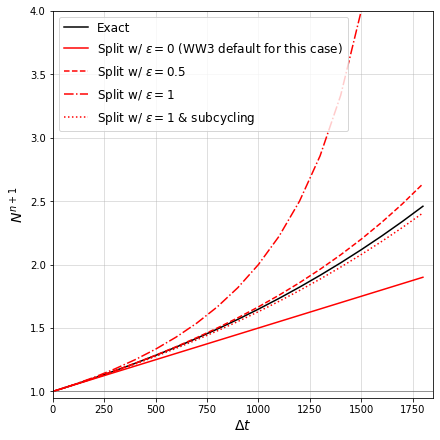

In [5]:
# CASE A has wind input but no ice damping
# so step 2 is zero, and hence the merged and split solutions are identical and not equal to exact
# Hence I'm only showing the split and ideal
# This case doesn't address the new merged solution but instead helps us understand
# step 1 of the split numerics a bit better.
# This is not a plausible case in longterm since exact solution is growing
# it is plausible in short term
# It demonstrates a useful point, namely that epsilon = 0.5 is much more accurate
# provided there is no denominator limiting henceforth simply "no limitor"
# With the limitor, epsilon has no influence and is effectively zero.
# We also see that if epsilon = 1.0 and without the limitor, the solution grows
# dangerously fast. No wonder they added the limitor. But 
# leaves me wondering why reject epsilon=0.5 with no limitor...
# The best choice is to subcycle
# For very small Delta t, all solutions converge as expected 

beta = -40.e-5
gamma = -1.25*beta
beta = 0.
combo = beta + gamma

## all should be true for plausible case in longterm
print(gamma >= 0, gamma < -beta, combo < 0)


fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6,6),
                        constrained_layout=True)

epsilon=0.5
dt, ideal, merge, splitp5, mergeL, splitLp5, merge_sub, split_subp5, Nstarsave, reverse = solutions(beta, gamma, epsilon)
epsilon=1
dt, ideal, merge, split1, mergeL, splitL1, merge_sub, split_sub1, Nstarsave, reverse = solutions(beta, gamma, epsilon)

ax1.plot(dt, ideal, c='k') 
ax1.plot(dt, splitLp5,ls='-',c='r')
ax1.plot(dt, splitp5,ls='--',c='r')
ax1.plot(dt, split1,ls='-.',c='r')
ax1.plot(dt, split_sub1, ls=':',c='r')
ax1.set_ylabel('$N^{n+1}$',fontsize=14)
ax1.set_xlabel('$\Delta t$',fontsize=14)
ax1.axhline(1,lw=0.5,c='0.3')
ax1.grid(True,alpha=0.5)
ax1.set_xlim(0,1850)
ax1.set_ylim(0.95,4)
ax1.legend(['Exact','Split w/ $\epsilon=0$ (WW3 default for this case)',
                'Split w/ $\epsilon=0.5$','Split w/ $\epsilon=1$',
                'Split w/ $\epsilon=1$ & subcycling'],fontsize=12, loc='upper left')
fig.savefig('CaseA.png', format="png", dpi=400)

True True True


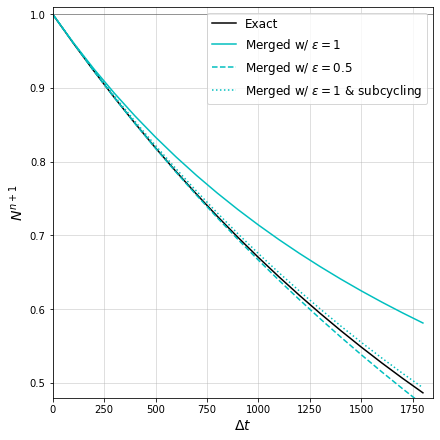

In [6]:
# CASE B has no wind input but does have ice damping
# so step 1 is zero and hence the original WW3 step 2 is equal to the exact and the new merged is an approximation 
# Hence this case demonstrate the error incurred by replacing the exact solution in step 2 with an approximation
# We also see that subcycling the new merged solution is great, so we should probably 
# subcycle at least in the sea ice
# For very small Delta t, all solutions converge as expected

beta = -40.e-5
gamma = 0.*beta
combo = beta + gamma

## all should be true for plausible case in longterm
print(gamma >= 0, gamma < -beta, combo < 0)


fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6,6),
                        constrained_layout=True)

epsilon=0.5
dt, ideal, mergep5, split, mergeL, splitL, merge_sub, split_sub, Nstarsave, reverse = solutions(beta, gamma, epsilon)

epsilon=1
dt, ideal, merge1, split, mergeL, splitL, merge_sub1, split_sub, Nstarsave, reverse = solutions(beta, gamma, epsilon)

ax1.plot(dt, ideal, c='k') 
ax1.plot(dt, merge1,ls='-',c='c')
ax1.plot(dt, mergep5,ls='--',c='c')
ax1.plot(dt, merge_sub1, ls=':',c='c')
ax1.set_ylabel('$N^{n+1}$',fontsize=14)
ax1.set_xlabel('$\Delta t$',fontsize=14)
ax1.axhline(1,lw=0.5,c='0.3')
ax1.grid(True,alpha=0.5)
ax1.set_xlim(0,1850)
ax1.set_ylim(0.48,1.01)
ax1.legend(['Exact','Merged w/ $\epsilon=1$',
                'Merged w/ $\epsilon=0.5$',
                'Merged w/ $\epsilon=1$ & subcycling'],fontsize=12, loc='upper right')

plt.show()
fig.savefig('CaseB.png', format="png", dpi=400)

# all red lines lie on top of Exact

gamma is  0.00030000000000000003   combo is  -9.999999999999999e-05
True True True


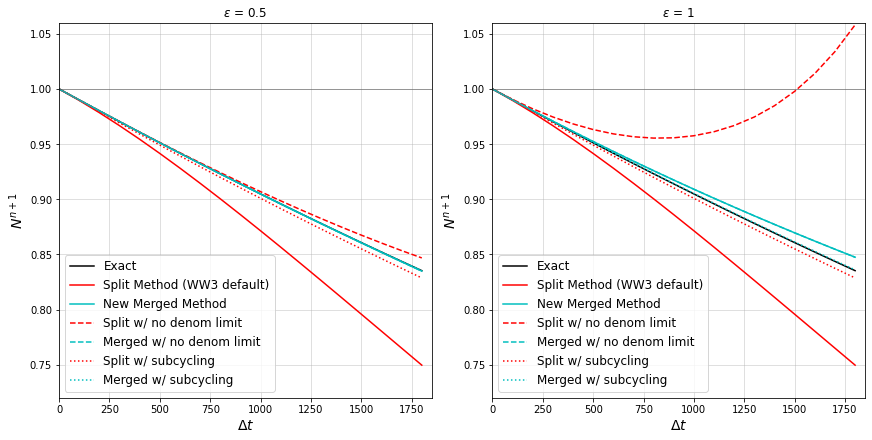

In [7]:
# CASE C: A bit less wind input than ice damping, combined steps is overall damping
# For very small Delta t, all solutions converge as expected
# This case is one where the original ww3 splitting solution overdamps,
# while the new improved merged solution is more accurate. 
# Subcycle always gives a pretty good solution
# with subcycling and merging the best possible
# This case has gamma>0 but is overall damping (beta+gamma<0). So step1 of the 
# split method activates the "limitor" in the denominator and therefore
# lacks higher order accuracy since the limitor inhibits accuracy.
# The limitor does not kick in for the merged method because
# beta+gamma < 0, so for this case, merging avoids the limitor and we never
# inhibit accuracy.
#
# Note if we ditch the limitor, even the split method with epsilon=0.5
# is quite good. However with epsilon=1.0, the split method is poor with
# or without the limitor
#
# Conclusion
#    1) subcycling makes any solution converge and is a safe choice
#    2) without subcyling, epsilon = 0.5 with no limitor is a reasonably good solution for split or merged
#    3) without subcyling, if we must stick with epsilion = 1.0 and the limitor, than a merged 
#       solution is a huge improvement over the split methood


beta = -40.e-5
gamma = -0.75*beta
combo = beta + gamma
print('gamma is ', gamma, '  combo is ', combo)

## all should be true for plausible case in longterm
print(gamma >= 0, gamma < -beta, combo < 0)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6),
                        constrained_layout=True)

epsilon=0.5
dt, ideal, merge, split, mergeL, splitL, merge_sub, split_sub, Nstarsave, reverse = solutions(beta, gamma, epsilon)
panelplot(ideal,mergeL,splitL, merge,split, merge_sub,split_sub,  axs[0])
axs[0].set_title('$\epsilon$ = 0.5')
axs[0].set_ylim(0.72,1.06)

epsilon=1
dt, ideal, merge, split, mergeL, splitL, merge_sub, split_sub, Nstarsave, reverse = solutions(beta, gamma, epsilon)
panelplot(ideal,mergeL,splitL, merge,split, merge_sub,split_sub,  axs[1])
axs[1].set_title('$\epsilon$ = 1')
axs[1].set_ylim(0.72,1.06)

plt.show()
fig.savefig('CaseC.png', format="png", dpi=400)

gamma is  0.0005   combo is  9.999999999999999e-05
True False False


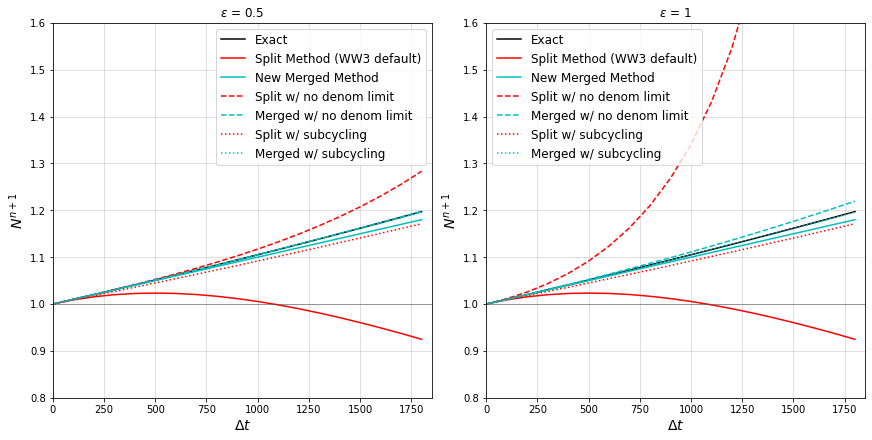

In [8]:
# CASE D A bit more wind input than ice damping so SHOULD BE overall growing, gamma = -1.25 beta 
# Here gamma>0 and gamma+beta>0
# Not a plausible case in the longterm since solution should grow,
# but could happen in short term.
# For very small Delta t, all solutions converge as expected. But for typical Delta t
# this case shows that the current ww3 solution is very poor, and in fact damps even when it should be growing
# for delta t > about 1000 s
# The original ww3 splitting solution always over damps compared to Exact
# while the new improved no splitting solution also over damps wrt Exact but less so.
# Subcycle always gives a pretty good solution
# with subcycling and no splitting the best possible

# This case helps us see why the merged solution is still best even though there is overall growth
# The limitor seems to be employed to reduce growth, even though it reduces accuracy
# The limitor is intended to avoid numerical growth since the numerical solution can really take off
# This happens when the denominator is less than 1, 
# making the numerical solution amplifying with respect to the exact solution
# The merged solution has far less of a problem with this "taking off" because gamma+beta < gamma 
# so it is less
# Further, with epsilon=0.5 and no limitor, grows wrt the exact is accurate to second order in Delta t.
# Even the third order term is pretty accurate for either split or merged (even more accurate for merged
# which is why the merged solution without the limitor is excellent, see cyan dashed line left panel below)

beta = -40.e-5
gamma = -1.25*beta
combo = beta + gamma
print('gamma is ', gamma, '  combo is ', combo)

## all should be true for plausible case in longterm
print(gamma >= 0, gamma < -beta, combo < 0)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6),
                        constrained_layout=True)

epsilon=0.5
dt, ideal, merge, split, mergeL, splitL, merge_sub, split_sub, Nstarsave, reverse = solutions(beta, gamma, epsilon)
panelplot(ideal,mergeL,splitL, merge,split, merge_sub,split_sub,  axs[0])
axs[0].set_title('$\epsilon$ = 0.5')
axs[0].set_ylim(0.8,1.6)

epsilon=1
dt, ideal, merge, split, mergeL, splitL, merge_sub, split_sub, Nstarsave, reverse = solutions(beta, gamma, epsilon)
panelplot(ideal,mergeL,splitL, merge,split, merge_sub,split_sub,  axs[1])
axs[1].set_title('$\epsilon$ = 1')
axs[1].set_ylim(0.8,1.6)

plt.show()
fig.savefig('CaseD.png', format="png", dpi=400)

## The rest is not important

gamma is  0.00030000000000000003   combo is  -9.999999999999999e-05
merge denom [1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13
 1.14 1.15 1.16 1.17 1.18]
split denom [1.   0.97 0.94 0.91 0.88 0.85 0.82 0.79 0.76 0.73 0.7  0.67 0.64 0.61
 0.58 0.55 0.52 0.49 0.46]
0.54
19
19


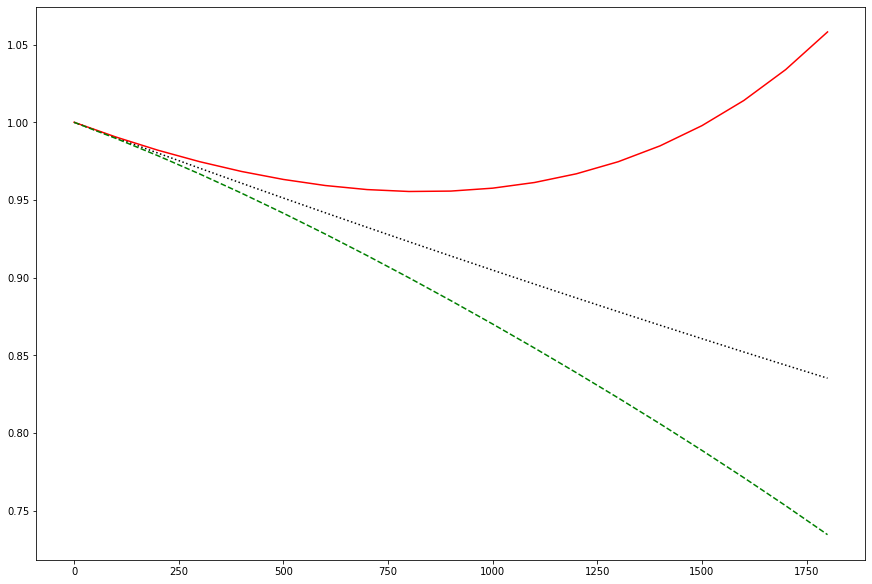

In [9]:
def expTSE(x):
    TSE = 1. + x + x*x/2 + x*x*x/6.
    return TSE

def geomseries(x):
    geomet = 1. + x + x*x + x*x*x 
    return geomet


def accuracy(beta, gamma):
    # beta is the exponent of the ice attenuation effect, beta = -aice*alpha*cg <= 0
    # as in S_ice = beta N 
    # gamma is a constant of proportionality for a linear input term
    # as in S_no ice = gamma N, gamma >= 0
    
    dtmin = 100. # this is the timestep for subcycling
    dt = np.arange(0.,1800.+dtmin,dtmin) # this is the global timestep, which we vary here
    combo = gamma + beta
    epsilon=1
    
    ## exact solution given no ice scattering and a linear non ice source
    ideal = N * np.exp(combo * dt) 
    
    ## no splitting approximation, merging non ice and ice together
    denom = 1 - epsilon * combo * dt
    denom = np.where(denom>1,denom, 1)    # the combo is often negative so then we don't replace denom with 1.
                                          # combo is always smaller than gamma since beta<0 so when we 
                                          # replace denom with 1, it is less inaccurate than for the splitting sol'n
    print('gamma is ', gamma, '  combo is ', combo)
    print('merge denom', denom)
    merge = N * (1 + combo * dt / denom) 

    ## time-splitting approximation, sums the two steps, Nstarsave is the intermediate step 
    denom = 1 - epsilon * gamma * dt
    #denom = np.where(denom>1,denom, 1)    # this makes it very inaccurate since gamma gamma>0 and hence denom = 1
                                          # effectively making espilon zero
    print('split denom', denom)
    Nstar = N * (1 + gamma * dt / denom)  
    split = Nstar * np.exp(beta * dt)

    idealTSE = expTSE(combo*dt)
    
    print(max(epsilon*gamma*dt))
    print(len(dt*gamma * geomseries(epsilon*gamma*dt)))
    print(len(expTSE(beta*dt)))

    if gamma<=0: 
        # this is not typical at all
        splitTSE = (expTSE(beta*dt))*(1. + dt*gamma * geomseries(epsilon*gamma*dt) )
    else:
        # this tends to be really inaccurate
        splitTSE = (expTSE(beta*dt))*(1. + dt*gamma)

    if combo<=0:
        mergeTSE = (1. + dt*combo * geomseries(epsilon*combo*dt) )
    else:
        # this tends to be less inaccurate since combo is at least smaller than gamma. Duh! What a dumb result
        mergeTSE = 1. + dt*combo
    
    return dt, ideal, merge, split, idealTSE, mergeTSE, splitTSE

beta = -40.e-5
gamma = -0.75*beta # solution is crummy when gamma is positive since then denom is limited to 1
#gamma = 0.75*beta # solution is great when gamma is negative since then denom is not 1 

dt, ideal, merge, split, idealTSE,  mergeTSE, splitTSE = accuracy(beta, gamma)

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(12,8),
                        constrained_layout=True)

ax1.plot(dt, ideal, ls = ':', c='k') 
#ax1.plot(dt, idealTSE, ls=':',c='r') 
#ax1.plot(dt, merge,ls='-',c='c')
#ax1.plot(dt, mergeTSE, ls='--',c='r') # a good approx of merge
ax1.plot(dt, split,ls='-',c='r')
ax1.plot(dt, splitTSE, ls='--',c='g')

#panelplot(ideal, merge, split, mergeTSE, splitTSE, idealTSE, idealTSE, axs)